In [1]:
import tensorflow as tf
import os
import IPython.display as ipd
from scipy.io import wavfile
import numpy as np
import librosa
from utils import (
    get_datasets,
    waveform_to_spectrograms,
    waveform_to_log_mel_spectrogram,
    eval_and_save,
    get_callbacks,
    get_background_noise,
    augment_fn,
)
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import (
    get_datasets,
    waveform_to_spectrograms,
    waveform_to_log_mel_spectrogram,
    eval_and_save,
    get_callbacks,
    CustomSchedule,
)
from Transformer import Transformer

2024-05-06 13:07:01.186227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 13:07:02.599507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds_train_raw, ds_val_raw, ds_test_raw = get_datasets()

Found 51088 files belonging to 30 classes.


2024-05-06 13:07:15.036288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:07:15.200586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:07:15.200678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:07:15.207858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:07:15.207972: I external/local_xla/xla/stream_executor

Found 6798 files belonging to 30 classes.
Found 6835 files belonging to 30 classes.


In [3]:
    sample_rate = 16000
    frame_length = 255
    frame_step = 128
    num_mel_bins = 129

In [12]:
# Model 8
path = "Transformer8.weights.h5"
config = {
    "Spectrogram": "Log-Mel",
    "Regularization": "Dropout",
    "Optimizer": "Adam",
    "Learning Rate": 0.0001,
    "Batch Size": 128,
    "d_model": 512,
    "num_layers": 4,
    "num_heads": 4,
    "dropout_rate": 0.2,
}

ds_train = (
    ds_train_raw.batch(config["Batch Size"])
    .map(
        lambda x, y: (
            waveform_to_log_mel_spectrogram(
                x,
                sample_rate=sample_rate,
                frame_length=frame_length,
                frame_step=frame_step,
                num_mel_bins=num_mel_bins,
            ),
            y,
        )
    )
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)
ds_val = (
    ds_val_raw.batch(config["Batch Size"])
    .map(
        lambda x, y: (
            waveform_to_log_mel_spectrogram(
                x,
                sample_rate=sample_rate,
                frame_length=frame_length,
                frame_step=frame_step,
                num_mel_bins=num_mel_bins,
            ),
            y,
        )
    )
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)
ds_test = (
    ds_test_raw.batch(config["Batch Size"])
    .map(
        lambda x, y: (
            waveform_to_log_mel_spectrogram(
                x,
                sample_rate=sample_rate,
                frame_length=frame_length,
                frame_step=frame_step,
                num_mel_bins=num_mel_bins,
            ),
            y,
        )
    )
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

model = Transformer(
    num_layers=config["num_layers"],
    d_model=config["d_model"],
    num_heads=config["num_heads"],
    dff=4 * config["d_model"],
    block_size=62,
    dropout_rate=config["dropout_rate"],
    num_classes=30,
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config["Learning Rate"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [5]:
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Decoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
optimizer = tf.keras.optimizers.Lion(learning_rate=1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
batch_size = 128
epochs = 3
for epoch in range(epochs):
    epoch_loss = 0
    step = 0
    for x_batch, y_batch in ds_train:
        step += 1
        with tf.GradientTape() as tape:
            # Forward pass


            outputs = model(x_batch, training=True)
            loss = loss_fn(y_batch, outputs)
            print(loss)
        # Backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        epoch_loss += loss.numpy() * batch_size

        if step == 1 and epoch == 0:
            model.load_weights("../models/" + path)


2024-05-06 13:07:28.377788: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


tf.Tensor(4.3503284, shape=(), dtype=float32)


/home/majkel/miniconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 144 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


tf.Tensor(0.008514402, shape=(), dtype=float32)
tf.Tensor(0.003144666, shape=(), dtype=float32)
tf.Tensor(0.001994903, shape=(), dtype=float32)
tf.Tensor(0.0035476158, shape=(), dtype=float32)
tf.Tensor(0.24402946, shape=(), dtype=float32)
tf.Tensor(0.1804948, shape=(), dtype=float32)
tf.Tensor(0.01711849, shape=(), dtype=float32)
tf.Tensor(0.21582201, shape=(), dtype=float32)
tf.Tensor(0.019021003, shape=(), dtype=float32)
tf.Tensor(0.031949077, shape=(), dtype=float32)
tf.Tensor(0.09080331, shape=(), dtype=float32)
tf.Tensor(0.011476635, shape=(), dtype=float32)
tf.Tensor(0.16952316, shape=(), dtype=float32)
tf.Tensor(0.082560465, shape=(), dtype=float32)


2024-05-06 13:07:40.333124: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

In [41]:
model.load_weights("../models/" + path)

/home/majkel/miniconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 144 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [42]:
preds = []
labels = []
loss_total = 0
correct = 0
batch_size = 128
for x_batch, y_batch in ds_test:
    if x_batch.shape[0] != batch_size:
        continue
    y_pred = model(x_batch)
    loss = model.loss(y_batch, y_pred)
    loss_total += loss
    preds.append(y_pred.numpy())
    labels.append(y_batch.numpy())
    correct += np.sum(np.argmax(y_pred, axis=1) == y_batch.numpy())

2024-05-06 13:12:43.767858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
correct / len(ds_test_raw), loss_total / len(ds_test_raw)

(0.9297732260424286, <tf.Tensor: shape=(), dtype=float32, numpy=0.0023905379>)

In [44]:
preds = model.predict(ds_test)

 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step


In [45]:
preds = np.argmax(preds, axis=1)

In [46]:
labels = np.concatenate([y for x, y in ds_test], axis=0)
labels

2024-05-06 13:13:08.315823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([20, 24, 12, ...,  5, 13, 29], dtype=int32)

In [47]:
classes = ds_train_raw.class_names

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(labels, preds)

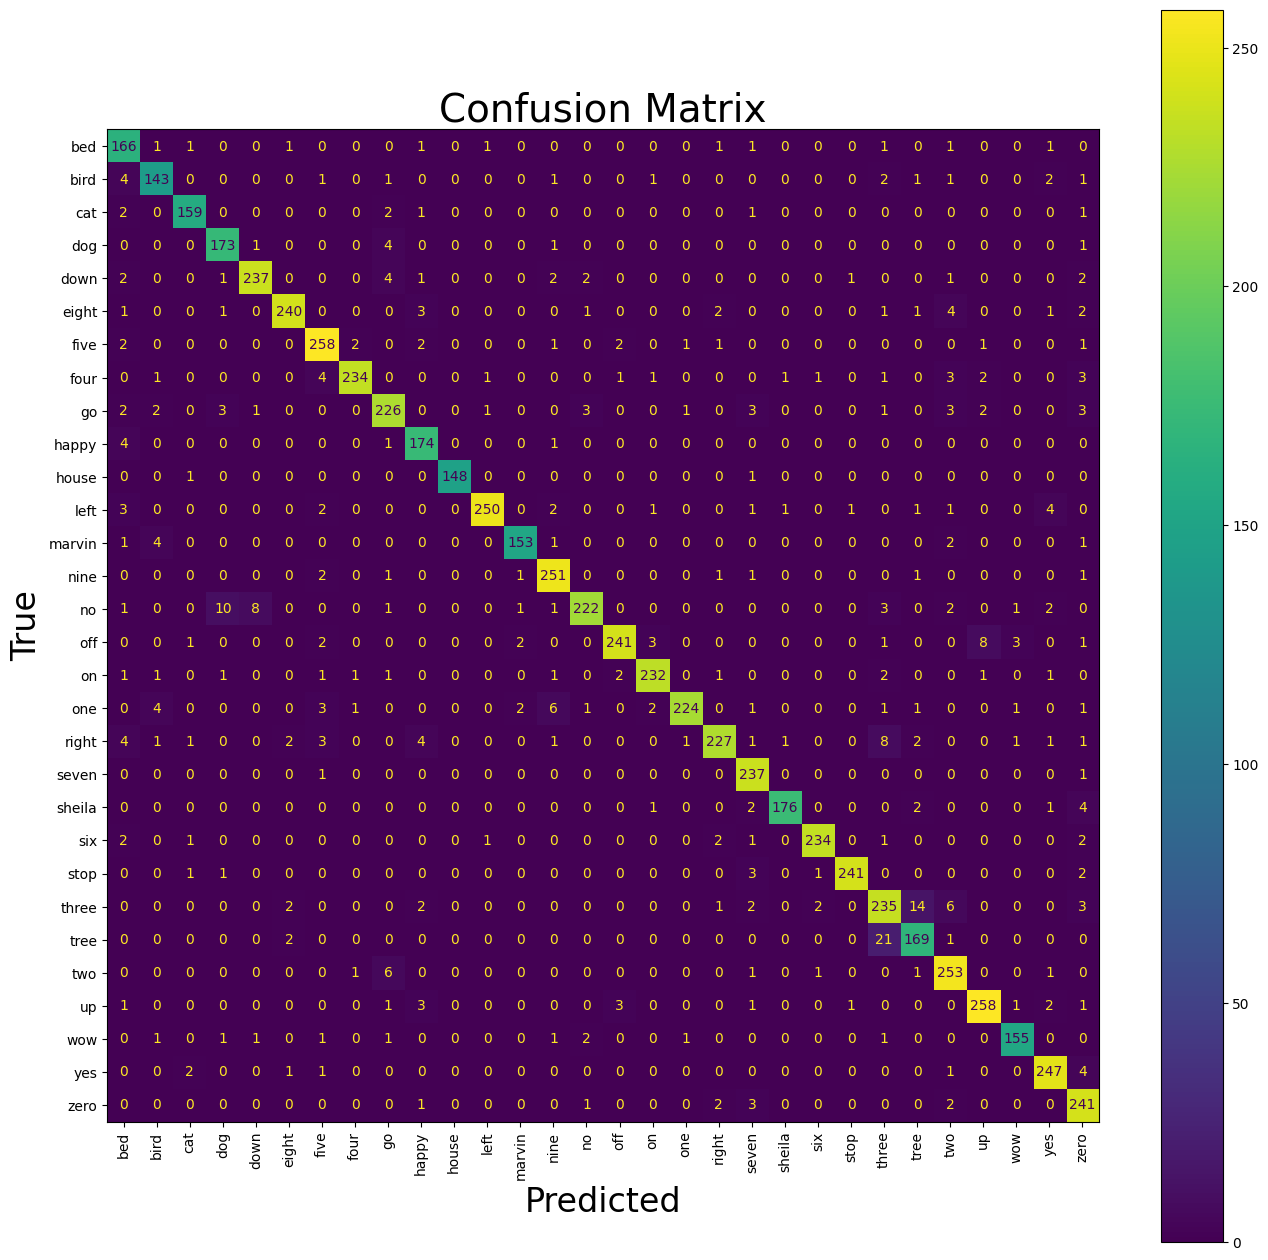

In [49]:
fig, ax = plt.subplots(figsize=(16, 16))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix", fontsize=28)
plt.xlabel("Predicted", fontsize=24)
plt.ylabel("True", fontsize=24)
plt.show()